In [273]:
# Import modules

import torch
from torch.nn import Module,ReLU,CrossEntropyLoss,LSTM
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader
from torch import nn
from torch.optim.lr_scheduler import StepLR

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import string
import random

In [274]:
torch.manual_seed(42)

In [275]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [276]:
# Read in data

data = pd.read_csv('names_generate.csv')
data = data.dropna()
data['names'] = data['names'].str.split().agg("".join)
data['names'] = data['names'].str.replace('\d+', '')
data['names'] = data['names'].str.encode('ascii', 'ignore').str.decode('ascii')
data.reset_index(drop=True, inplace=True)
print(f"Data Shape: {data.shape}")

Data Shape: (20074, 2)


/var/folders/_n/97hhqsmx7pz8l855zd6lsc0c0000gn/T/ipykernel_90709/301001692.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  data['names'] = data['names'].str.replace('\d+', '')


In [277]:
# Convert names and categories to lower  case

data['names'] = data.names.str.lower()
data['category'] = data.category.str.lower()

data

,category,names
0,czech,abl
1,czech,adsit
2,czech,ajdrna
3,czech,alt
4,czech,antonowitsch
...,...,...
20069,polish,zdunowski
20070,polish,zielinski
20071,polish,ziemniak
20072,polish,zientek


In [278]:
# Train test split

train = data.sample(frac=0.95, axis=0,random_state=42)
train.reset_index(drop=True, inplace=True)

test = data.drop(index=train.index)
test.reset_index(drop=True, inplace=True)
print(train,'\n',test)

       category       names
0       russian  kalgashkin
1        arabic        deeb
2       russian     janzhul
3       russian  tchekhonin
4      japanese       genji
...         ...         ...
19065   russian    babienko
19066   english    kearsley
19067   russian    mordovin
19068   russian   abrasimov
19069   chinese         sze

[19070 rows x 2 columns] 
      category       names
0     italian      marino
1     italian       marmo
2     italian    martelli
3     italian  martinelli
4     italian        masi
...       ...         ...
999    polish   zdunowski
1000   polish   zielinski
1001   polish    ziemniak
1002   polish     zientek
1003   polish        uraw

[1004 rows x 2 columns]


In [279]:
# Create character index
char_idx = {}
char_idx['<sos>'] = 0
char_idx['<eos>'] = 1
characters =  string.ascii_lowercase
for i,char in enumerate(characters):
        char_idx[char] = i+2
print(char_idx)

# Create index to character
idx_char = dict([(value, key) for key, value in char_idx.items()])
print('\n',idx_char)

{'<sos>': 0, '<eos>': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27}

 {0: '<sos>', 1: '<eos>', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z'}


In [280]:
# Create country index

cat_idx = {}
category = data.category
for country in category:
        if country not in cat_idx:
            cat_idx[country] = len(cat_idx)

# Create index to category
idx_cat = dict([(value, key) for key, value in cat_idx.items()])
print(cat_idx,'\n','\n',idx_cat)

{'czech': 0, 'german': 1, 'arabic': 2, 'japanese': 3, 'chinese': 4, 'vietnamese': 5, 'russian': 6, 'french': 7, 'irish': 8, 'english': 9, 'spanish': 10, 'greek': 11, 'italian': 12, 'portuguese': 13, 'scottish': 14, 'dutch': 15, 'korean': 16, 'polish': 17} 
 
 {0: 'czech', 1: 'german', 2: 'arabic', 3: 'japanese', 4: 'chinese', 5: 'vietnamese', 6: 'russian', 7: 'french', 8: 'irish', 9: 'english', 10: 'spanish', 11: 'greek', 12: 'italian', 13: 'portuguese', 14: 'scottish', 15: 'dutch', 16: 'korean', 17: 'polish'}


In [281]:
# Dataset class

class Names(Dataset):
    def __init__(self,dataframe,char_idx,idx_char,cat_idx,idx_cat):
        super(Names,self).__init__()
        self.names = dataframe['names']
        self.category = dataframe['category']
        self.char_idx = char_idx
        self.idx_char = idx_char
        self.cat_idx = cat_idx
        self.idx_cat = idx_cat
        
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self,idx):
        name = self.names.loc[idx]
        name = [self.char_idx[i] for i in self.names.loc[idx]]
        category = self.cat_idx[self.category.loc[idx]]
        return (torch.tensor(name),torch.tensor(category))
    
    def char_idx(self):
        char_idx = self.char_idx
        return char_idx
    
    def idx_char(self,x):
        idx_char = self.idx_char[x] 
        return idx_char
        

In [282]:
# Instantiate required objects

train_data = Names(train,char_idx,idx_char,cat_idx,idx_cat)
test_data = Names(test,char_idx,idx_char,cat_idx,idx_cat)

In [283]:
# Check output

print(train_data.__getitem__(0),'\n','\n',test_data.__getitem__(0))

(tensor([12,  2, 13,  8,  2, 20,  9, 12, 10, 15]), tensor(6)) 
 
 (tensor([14,  2, 19, 10, 15, 16]), tensor(12))


In [284]:
# # Test methods

# print(train_data.__len__())
# print(idx_cat[train_data.__getitem__(0)[1].item()])
# print(train_data.char_idx['a'])
# print(train_data.idx_char[0])

In [285]:
# Creating the data for supervised learning (features,labels)

def collate_fn(batch):
    max_length = max([len(name[0]) for name in batch])
    padded_names = torch.zeros((len(batch), max_length), dtype=torch.long)
    category_names = torch.zeros((len(batch),max_length),dtype=torch.long)
    # print(padded_names.size(),category_names.size())
    for i, name in enumerate(batch):
        padded_names[i, :len(name[0])] = name[0]
        category_names[i, :len(name[0])] = name[1]
    return category_names[:, :-1],padded_names[:, :-1], padded_names[:, 1:]

In [286]:
# Creating mini-batch data feed 

train_loader = DataLoader(train_data,batch_size=512,shuffle=True,collate_fn=collate_fn)
test_loader = DataLoader(train_data,batch_size= 64,shuffle=True,collate_fn=collate_fn)

In [287]:
# # # Test Train Loader
# next(iter(test_loader))

In [288]:
# Model Class

class Name(nn.Module):
    def __init__(self, num_categories, num_chars, category_embedding_dim, char_embedding_dim, hidden_dim,n_layers=1):
        super(Name, self).__init__()
        
        self.n_layers = n_layers
        self.hidden_size = hidden_dim
        self.char_embedding = nn.Embedding(num_chars, char_embedding_dim)
        self.category_embedding = nn.Embedding(num_categories, category_embedding_dim)
        self.lstm = nn.LSTM(category_embedding_dim + char_embedding_dim,hidden_dim, n_layers,batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_chars)

    def forward(self, category_input, char_input, hidden_state):
        category_embedded = self.category_embedding(category_input)
        char_embedded = self.char_embedding(char_input)
        combined_embedded = torch.cat((category_embedded, char_embedded), dim=-1)
        
        lstm_output, (hidden, cell) = self.lstm(combined_embedded)
        logits = self.fc(lstm_output)
        return logits, (hidden, cell)
    
    def init_state(self, b_size=1):
        return (torch.zeros(self.n_layers, b_size, self.hidden_size),
                torch.zeros(self.n_layers, b_size, self.hidden_size))

In [289]:
# Initialize variables

num_categories = len(idx_cat)
num_chars = len(idx_char)
category_embedding_dim = 8
char_embedding_dim = 8
hidden_dim = 128
n_layers = 4

In [290]:
# Instiate model object

name  = Name(len(idx_cat),len(idx_char),category_embedding_dim,char_embedding_dim,hidden_dim,n_layers).to(device)

# Test init state method
h,c = name.init_state()
h.size(),c.size()

(torch.Size([4, 1, 128]), torch.Size([4, 1, 128]))

In [291]:
# Initialize training related variables and functions

losses =[]
loss_per_epoch = []
hidden_cell = name.init_state(32)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(name.parameters(), lr=0.01)

num_epochs = 20

In [292]:
# Training loop
for epoch in range(num_epochs):
    correct = 0
    total = 0
    for batch_idx, (category_input, char_input, target) in enumerate(train_loader):
        category_input = category_input.to(device)
        char_input = char_input.to(device)
        target = target.to(device)
        name.train()
        optimizer.zero_grad()
        
        # Forward pass
        logits,(hidden_cell)  = name(category_input, char_input,(hidden_cell))
       
        
        # Reshape the logits and targets
        logits = logits.view(-1, num_chars) # Shape: (batch_size * sequence_length, num_chars)
        target = target.reshape(-1)             # Shape: (batch_size * sequence_length)
        
        # Compute the loss
        loss = criterion(logits,target)
        losses.append(loss.item())
        # Backward pass
        loss.backward()
        
        _,predicted = torch.max(logits.data, 1)
                
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        
        # Update the model parameters
        optimizer.step()
    
    train_acc = 100 * correct / total        
    loss_per_epoch.append(loss.item())
    print(f"Epoch:{epoch} Loss: {loss} Test Accuracy: {train_acc:.2f}%")


Epoch:0 Loss: 1.7901134490966797 Test Accuracy: 56.15%
Epoch:1 Loss: 1.5453481674194336 Test Accuracy: 60.34%
Epoch:2 Loss: 0.8320987224578857 Test Accuracy: 64.88%
Epoch:3 Loss: 1.4097964763641357 Test Accuracy: 67.21%
Epoch:4 Loss: 1.1202508211135864 Test Accuracy: 68.33%
Epoch:5 Loss: 1.0470623970031738 Test Accuracy: 69.86%
Epoch:6 Loss: 1.1486082077026367 Test Accuracy: 71.44%
Epoch:7 Loss: 1.0378323793411255 Test Accuracy: 72.39%
Epoch:8 Loss: 1.0283328294754028 Test Accuracy: 73.29%
Epoch:9 Loss: 0.8840490579605103 Test Accuracy: 73.96%
Epoch:10 Loss: 0.9194986820220947 Test Accuracy: 74.85%
Epoch:11 Loss: 0.9584630727767944 Test Accuracy: 75.25%
Epoch:12 Loss: 0.8372374773025513 Test Accuracy: 76.26%
Epoch:13 Loss: 0.7661874890327454 Test Accuracy: 76.79%
Epoch:14 Loss: 0.8276225328445435 Test Accuracy: 77.36%
Epoch:15 Loss: 0.7626478672027588 Test Accuracy: 78.02%
Epoch:16 Loss: 0.6365481019020081 Test Accuracy: 78.28%
Epoch:17 Loss: 0.6574936509132385 Test Accuracy: 78.72%
Ep

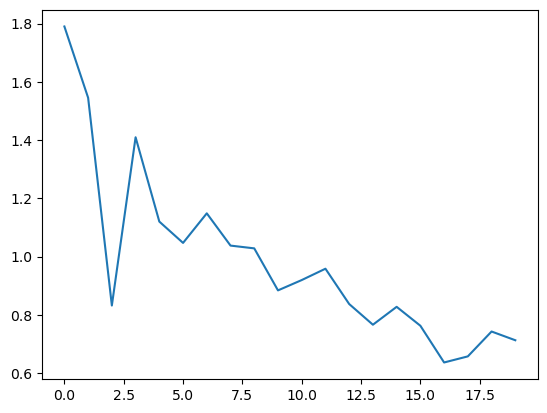

In [293]:
plt.plot(loss_per_epoch)

In [294]:
 # Test performance on test data
name.eval()
optimizer.zero_grad()
correct = 0
total = 0
with torch.no_grad():
    for batch_idx, (category_input, char_input, target) in enumerate(test_loader):
        category_input = category_input.to(device)
        char_input = char_input.to(device)
        target = target.to(device)
        logits,_  = name(category_input, char_input,(hidden_cell))
        logits = logits.view(-1, num_chars) # Shape: (batch_size * sequence_length, num_chars)
        target = target.reshape(-1)             # Shape: (batch_size * sequence_length)
        _,predicted = torch.max(logits.data, 1)

        total += target.size(0)
        correct += (predicted == target).sum().item()
        test_acc = 100 * correct / total
    print(test_acc)

77.44216687131961


In [295]:
# Name generation function

def generate_name(model, category_input, char_idx, idx_char, first_char,max_length, temperature=0.75):
    # Set the initial input character and the provided category
    
    char_input = torch.tensor([char_idx[first_char]], dtype=torch.long).to(device)
    category_input = torch.tensor([category_input], dtype=torch.long).to(device)
    hidden_state = model.init_state()
    # # Move inputs to the same device as the model
    # category_input = category_input.to(model.device)
    # char_input = char_input.to(model.device)

    generated_name = first_char + ""
    
    model.eval()
    optimizer.zero_grad()

    # Generate characters until the <end> token is sampled or max_length is reached
    for _ in range(max_length):
        
        
        with torch.no_grad():
            # Predict the next character using the model
            category_input = category_input.to(device)
            char_input = char_input.to(device)
            logits, (hidden_state) = model(category_input, char_input,(hidden_state))

            # prev_state = hidden_state[0]
            probs = torch.softmax(logits / temperature, dim=-1).squeeze(0)

            # Sample the next character from the output probabilities
            next_char_idx = torch.multinomial(probs, 1).item()

            next_char = idx_char[next_char_idx]

            # Check if the <end> token is sampled
            if next_char == '<eos>' or next_char == '<sos>':
                break

            # Add the sampled character to the generated name
            generated_name += next_char

            # Set the current input as the next character
            char_input = torch.tensor([next_char_idx], dtype=torch.long).to(device)

    return generated_name


In [325]:
# Name generation 

key = random.choice(list(cat_idx))
category_input = cat_idx[key]

generated_name = generate_name(name, category_input, char_idx, idx_char, first_char = 'z', max_length=8)
print(f"Generated name for country {key}: {generated_name}")


Generated name for country irish: zelesurul


In [326]:
# More names
cntry = ['japanese', 'french', 'korean','scottish']

for c in cntry:
    idx = cat_idx[c]
    first_char =  idx_char[np.random.choice(17,1).item()]
    if first_char == '<sos>' or first_char == '<eos>':
        first_char = 's'
        
    new_name = generate_name(name, idx, char_idx, idx_char, first_char,max_length=8)
    print(f"Starting with characeter: {first_char} the generated name for country {c}: {new_name}")

Starting with characeter: m the generated name for country japanese: mishimana
Starting with characeter: b the generated name for country french: balamedes
Starting with characeter: s the generated name for country korean: sunainyal
Starting with characeter: g the generated name for country scottish: gaseledit
